In [1]:
%matplotlib inline 

In [2]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import PIL

from datasets.ICDAR.ICDAR import IcdarMerge
from utils.visualization import create_merge_result_image

In [3]:
ds = tfds.load('icdar_merge', split='test')

2022-02-08 10:08:09.944701: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

2022-02-08 10:08:13.116166: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-02-08 10:08:13.599715: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open checkpoints/split.ckpt: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Shuffling icdar_merge-train.tfrecord...:   0%|          | 0/92 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling icdar_merge-test.tfrecord...:   0%|          | 0/148 [00:00<?, ? examples/s]

Dataset icdar_merge downloaded and prepared to /root/tensorflow_datasets/icdar_merge/1.0.1. Subsequent calls will reuse this data.


2022-02-08 10:09:44.361258: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


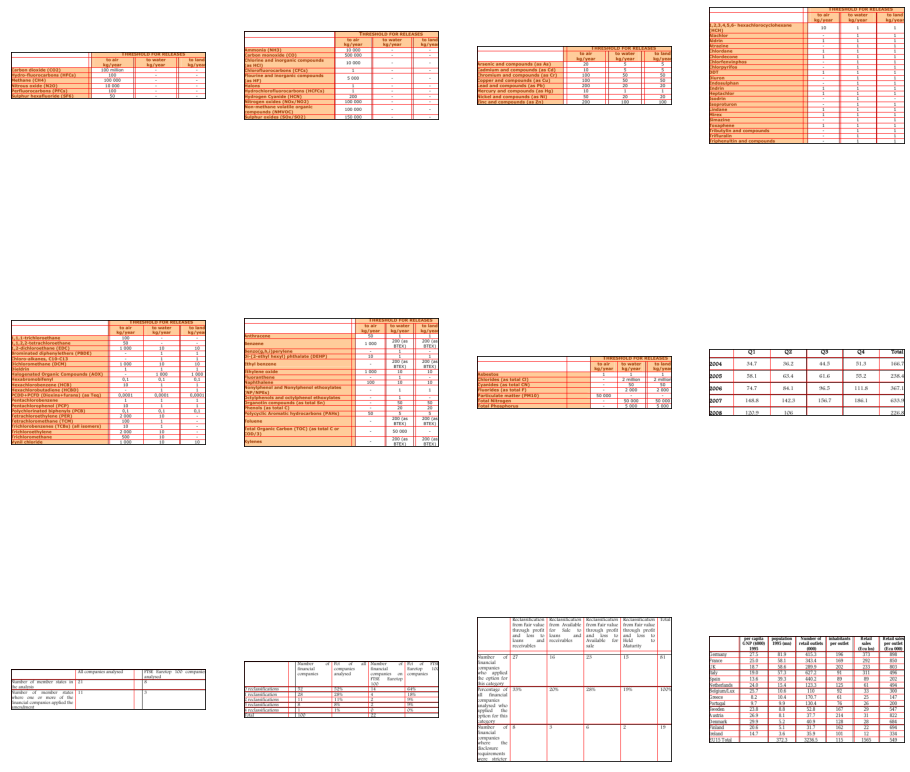

In [4]:
fig, axes = plt.subplots(3, 4, figsize=(16,16))

for element, ax in zip(ds.take(12), axes.flat):
    table_image = PIL.Image.fromarray(element['image'].numpy())
    debug_image = create_merge_result_image(
        table_image, 
        element['horz_split_points_binary'].numpy(), 
        element['vert_split_points_binary'].numpy(),
        element['merge_right_mask'].numpy(),
        element['merge_down_mask'].numpy()
    )
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(debug_image)
plt.show()